# Notebook for Denoising SPECT Images

In this notebook we will try to create a neural network that will denoise simulated SPECT images.

First we import some libraries:

In [1]:
%matplotlib inline
from fastai.basics import *
from fastai.vision import *
import fastai
from fastai.callbacks import *
from fastai.vision.gan import *
import random
import os

## (1) Making directories and checking the images.

In [74]:
path = Path('proj')

#creates the path in which the folders of the images are in.

In [75]:
path.ls()

#shows the path where the low- and high-count images are put.

[PosixPath('proj/low_count'), PosixPath('proj/high_count')]

In [44]:
path_low = path/'low_count'
path_high = path/'high_count'

#creates two paths to the image-directories

The following line of code makes two lists: 
* A list of high-resolution images
* A list of low-resolution images


In [76]:
high_images = get_image_files(path_high)   #high res images list
low_images = get_image_files(path_low)     #low res image list
print('Length of low count is', len(low_images))
print('Length of high counts is', len(high_images))

Length of low count is 378
Length of high counts is 378


##### FIXED: The lengths are equal and all the abundant images are deleted.

Here, we see that the length of the two lists are not equal. This will cause problems in further coding. This needs a fix.

Next to that, it is not sure if the lists have the same sorting. This also needs a check and possibly a fix.

## (2) Fixing the length of the lists and deleting abundant images.

We want to convert ```high_images``` and ```low_images``` to lists that include strings.

The converted lists must be sorted and can then be compared to find out where the excessive images are located.
These can then be deleted.

In [59]:
length_low = len(low_images)
length_high = len(high_images)

low_str = [0]*length_low #instantiate a zero list
i = 0
for i in range(0,length_low):
    low_str[i] = os.path.basename(low_images[i]);

#These loops create a list which includes the strings of each image.
    
high_str = [0]*length_high #instantiate a zero list
j = 0
for j in  range(0,length_high):
    high_str[j] = os.path.basename(high_images[j]);

#sorting the lists and zipping them together:
low_str.sort()
high_str.sort()
l = zip(low_str, high_str)
list(l)


378 378


[('proj_10a_bp1.jpg', 'proj_10a_bp1.jpg'),
 ('proj_10a_bp2.jpg', 'proj_10a_bp2.jpg'),
 ('proj_10a_bp3.jpg', 'proj_10a_bp3.jpg'),
 ('proj_10a_bp4.jpg', 'proj_10a_bp4.jpg'),
 ('proj_10a_bp5.jpg', 'proj_10a_bp5.jpg'),
 ('proj_10a_bp6.jpg', 'proj_10a_bp6.jpg'),
 ('proj_10a_bp7.jpg', 'proj_10a_bp7.jpg'),
 ('proj_10a_bp8.jpg', 'proj_10a_bp8.jpg'),
 ('proj_10a_bp9.jpg', 'proj_10a_bp9.jpg'),
 ('proj_10b_bp1.jpg', 'proj_10b_bp1.jpg'),
 ('proj_10b_bp2.jpg', 'proj_10b_bp2.jpg'),
 ('proj_10b_bp3.jpg', 'proj_10b_bp3.jpg'),
 ('proj_10b_bp4.jpg', 'proj_10b_bp4.jpg'),
 ('proj_10b_bp5.jpg', 'proj_10b_bp5.jpg'),
 ('proj_10b_bp6.jpg', 'proj_10b_bp6.jpg'),
 ('proj_10b_bp7.jpg', 'proj_10b_bp7.jpg'),
 ('proj_10b_bp8.jpg', 'proj_10b_bp8.jpg'),
 ('proj_10b_bp9.jpg', 'proj_10b_bp9.jpg'),
 ('proj_10c_bp1.jpg', 'proj_10c_bp1.jpg'),
 ('proj_10c_bp2.jpg', 'proj_10c_bp2.jpg'),
 ('proj_10c_bp3.jpg', 'proj_10c_bp3.jpg'),
 ('proj_10c_bp4.jpg', 'proj_10c_bp4.jpg'),
 ('proj_10c_bp5.jpg', 'proj_10c_bp5.jpg'),
 ('proj_10c

Ok, now we have two sorted lists of strings only.

Next step is deleting the strings that are not present in both lists.

#i = 0
#len_diff = abs(len(low_str)-len(high_str))
#for i in range(0,(len_diff-1))
k = 0
location = path_low
while low_str[k] == high_str[k]:
    k += 1
    print(k)
else: 
    print('what else')
    #pathloop = os.path.join(location, low_str[k])
    #os.remove(pathloop)



Above, I have deleted the images that were present in the low-count folder but were missing in the high-count folder.


This is an image of a random item out of the low-count images list.
The index of the image is 58


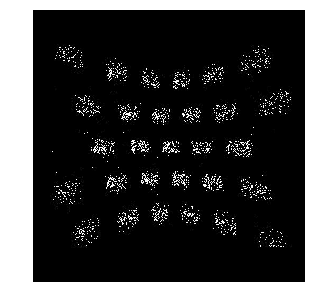

In [64]:
show_low = low_images[random.randint(0,len(low_images))]
img = open_image(show_low)
img.show(figsize=(5, 5))
print('This is an image of a random item out of the low-count images list.')
print('The index of the image is', low_images.index(show_low))

## Creating the Databunch

In [65]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_high/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

src = ImageImageList.from_folder(path_low).split_by_rand_pct(0.1, seed=42)
data_gen = get_data(bs=8,size=128)

#this creates the databunch.

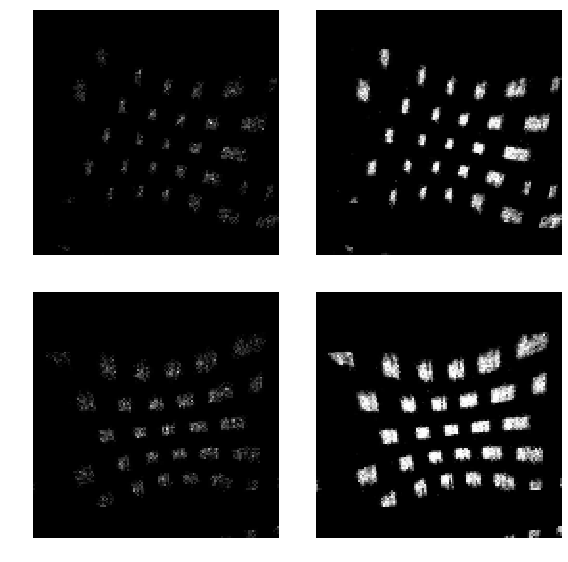

In [67]:
data_gen.show_batch(2)

#this will show 4 datasets of high- and low-count images.

## Simple Generator

In [68]:
wd = 1e-3
y_range = (-3.,3.)
loss_gen = MSELossFlat()

In [69]:
def create_gen_learner(wd, data_gen, y_range, loss_gen):
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

arch = models.resnet34
learn_gen = create_gen_learner(wd, data_gen, y_range, loss_gen)

Here we create a generator. The generator is trained using transfer learning so it starts with a basic understanding of what images look like.

epoch,train_loss,valid_loss,time
0,0.710810,0.218900,00:22
1,0.328606,0.103736,00:10


epoch,train_loss,valid_loss,time
0,0.151800,0.107308,00:12
1,0.148525,0.096184,00:12
2,0.137098,0.086719,00:12


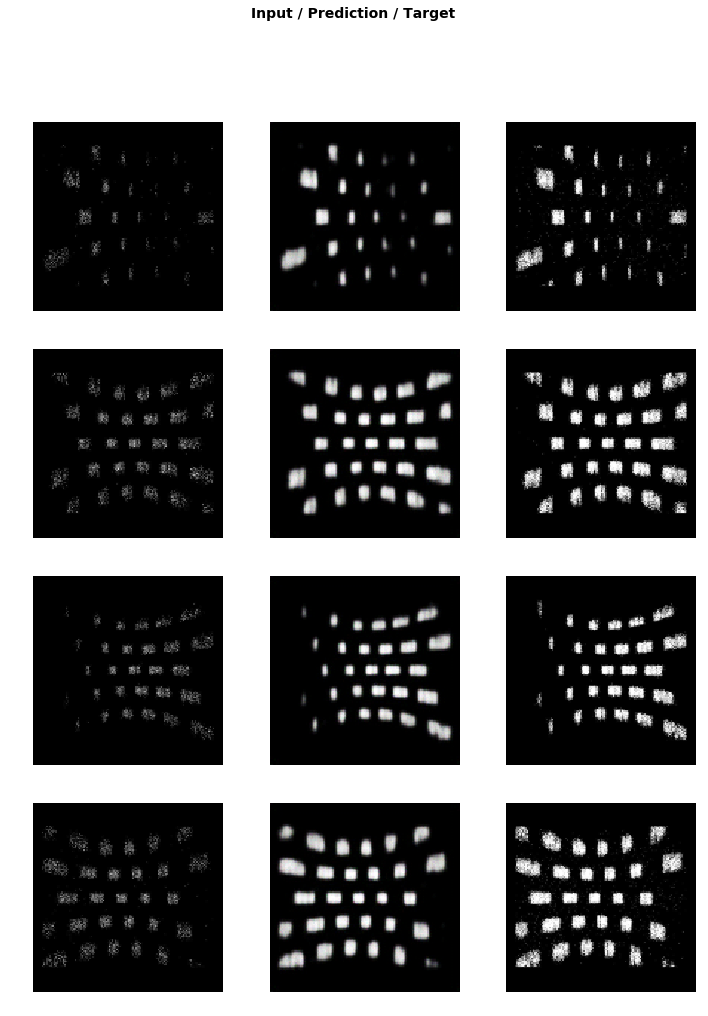

In [70]:
learn_gen.fit_one_cycle(2, pct_start=0.8)
learn_gen.unfreeze()
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))
learn_gen.show_results(rows=4)

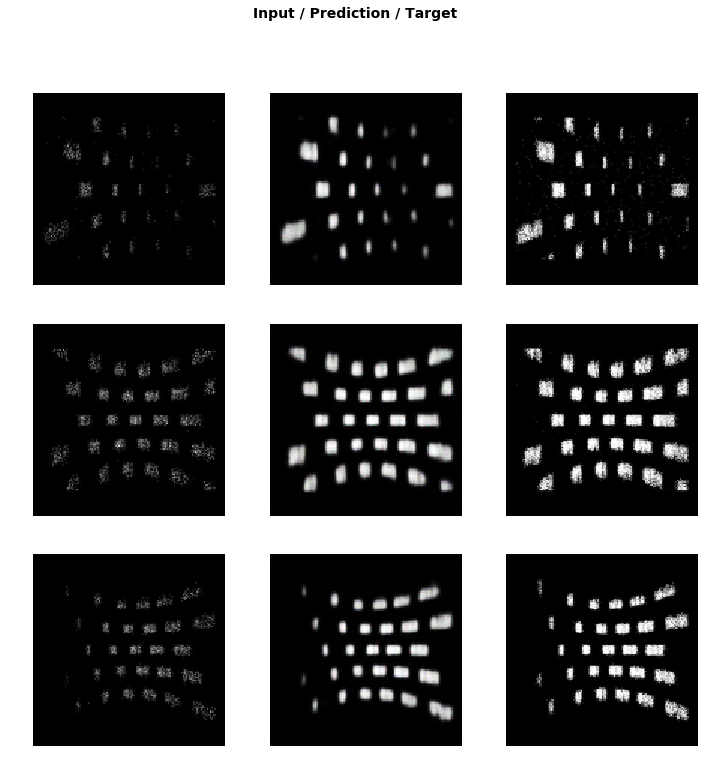

In [73]:
learn_gen.show_results(rows=3)